

# Line Graph Neural Network

**Author**: [Qi Huang](https://github.com/HQ01), Yu Gai,
[Minjie Wang](https://jermainewang.github.io/), Zheng Zhang

<div class="alert alert-danger"><h4>Warning</h4><p>The tutorial aims at gaining insights into the paper, with code as a mean
    of explanation. The implementation thus is NOT optimized for running
    efficiency. For recommended implementation, please refer to the [official
    examples](https://github.com/dmlc/dgl/tree/master/examples).</p></div>


In this tutorial, you learn how to solve community detection tasks by implementing a line
graph neural network (LGNN). Community detection, or graph clustering, consists of partitioning
the vertices in a graph into clusters in which nodes are more similar to
one another.

In the :doc:`Graph convolutinal network tutorial <1_gcn>`, you learned how to classify the nodes of an input
graph in a semi-supervised setting. You used a graph convolutional neural network (GCN)
as an embedding mechanism for graph features.

To generalize a graph neural network (GNN) into supervised community detection, a line-graph based
variation of GNN is introduced in the research paper
[Supervised Community Detection with Line Graph Neural Networks](https://arxiv.org/abs/1705.08415)_.
One of the highlights of the model is
to augment the straightforward GNN architecture so that it operates on
a line graph of edge adjacencies, defined with a non-backtracking operator.

A line graph neural network (LGNN) shows how DGL can implement an advanced graph algorithm by
mixing basic tensor operations, sparse-matrix multiplication, and message-
passing APIs.

In the following sections, you learn about community detection, line
graphs, LGNN, and its implementation.

## Supervised community detection task with the Cora dataset
Community detection
~~~~~~~~~~~~~~~~~~~~
In a community detection task, you cluster similar nodes instead of
labeling them. The node similarity is typically described as having higher inner
density within each cluster.

What's the difference between community detection and node classification？
Comparing to node classification, community detection focuses on retrieving
cluster information in the graph, rather than assigning a specific label to
a node. For example, as long as a node is clustered with its community
members, it doesn't matter whether the node is assigned as "community A",
or "community B", while assigning all "great movies" to label "bad movies"
will be a disaster in a movie network classification task.

What's the difference then, between a community detection algorithm and
other clustering algorithm such as k-means? Community detection algorithm operates on
graph-structured data. Comparing to k-means, community detection leverages
graph structure, instead of simply clustering nodes based on their
features.

### Cora dataset
To be consistent with the GCN tutorial,
you use the [Cora dataset](https://linqs.soe.ucsc.edu/data)_
to illustrate a simple community detection task. Cora is a scientific publication dataset,
with 2708 papers belonging to seven
different machine learning fields. Here, you formulate Cora as a
directed graph, with each node being a paper, and each edge being a
citation link (A->B means A cites B). Here is a visualization of the whole
Cora dataset.

.. figure:: https://i.imgur.com/X404Byc.png
   :alt: cora
   :height: 400px
   :width: 500px
   :align: center

Cora naturally contains seven classes, and statistics below show that each
class does satisfy our assumption of community, i.e. nodes of same class
class have higher connection probability among them than with nodes of different class.
The following code snippet verifies that there are more intra-class edges
than inter-class.



In [1]:
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl.data import citation_graph as citegrh

data = citegrh.load_cora()

G = data[0]
labels = th.tensor(G.ndata["label"])

# find all the nodes labeled with class 0
label0_nodes = th.nonzero(labels == 0, as_tuple=False).squeeze()
# find all the edges pointing to class 0 nodes
src, _ = G.in_edges(label0_nodes)
src_labels = labels[src]
# find all the edges whose both endpoints are in class 0
intra_src = th.nonzero(src_labels == 0, as_tuple=False)
print("Intra-class edges percent: %.4f" % (len(intra_src) / len(src_labels)))

import matplotlib.pyplot as plt

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Intra-class edges percent: 0.6994


/tmp/ipykernel_1249720/2778831166.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = th.tensor(G.ndata["label"])


### Binary community subgraph from Cora with a test dataset
Without loss of generality, in this tutorial you limit the scope of the
task to binary community detection.

<div class="alert alert-info"><h4>Note</h4><p>To create a practice binary-community dataset from Cora, first extract
   all two-class pairs from the original Cora seven classes. For each pair, you
   treat each class as one community, and find the largest subgraph that
   at least contains one cross-community edge as the training example. As
   a result, there are a total of 21 training samples in this small dataset.</p></div>

With the following code, you can visualize one of the training samples and its community structure.



Done loading data into cached files.
Done loading data from cached files.


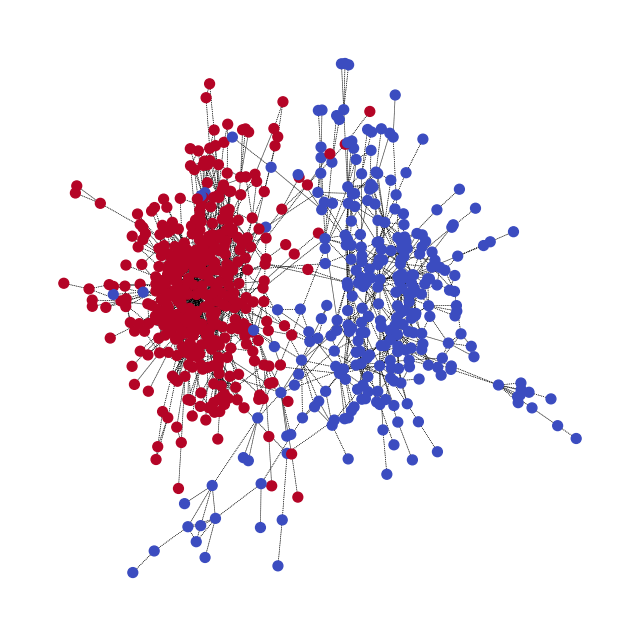

In [2]:
import networkx as nx

train_set = dgl.data.CoraBinary()
G1, pmpd1, label1 = train_set[1]
nx_G1 = G1.to_networkx()


def visualize(labels, g):
    pos = nx.spring_layout(g, seed=1)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    nx.draw_networkx(
        g,
        pos=pos,
        node_size=50,
        cmap=plt.get_cmap("coolwarm"),
        node_color=labels,
        edge_color="k",
        arrows=False,
        width=0.5,
        style="dotted",
        with_labels=False,
    )


visualize(label1, nx_G1)

To learn more, go the original research paper to see how to generalize
to multiple communities case.

### Community detection in a supervised setting
The community detection problem could be tackled with both supervised and
unsupervised approaches. You can formulate
community detection in a supervised setting as follows:

- Each training example consists of $(G, L)$, where $G$ is a
  directed graph $(V, E)$. For each node $v$ in $V$, we
  assign a ground truth community label $z_v \in \{0,1\}$.
- The parameterized model $f(G, \theta)$ predicts a label set
  $\tilde{Z} = f(G)$ for nodes $V$.
- For each example $(G,L)$, the model learns to minimize a specially
  designed loss function (equivariant loss) $L_{equivariant} =
  (\tilde{Z}，Z)$

<div class="alert alert-info"><h4>Note</h4><p>In this supervised setting, the model naturally predicts a label for
   each community. However, community assignment should be equivariant to
   label permutations. To achieve this, in each forward process, we take
   the minimum among losses calculated from all possible permutations of
   labels.

   Mathematically, this means
   $L_{equivariant} = \underset{\pi \in S_c} {min}-\log(\hat{\pi}, \pi)$,
   where $S_c$ is the set of all permutations of labels, and
   $\hat{\pi}$ is the set of predicted labels,
   $- \log(\hat{\pi},\pi)$ denotes negative log likelihood.

   For instance, for a sample graph with node $\{1,2,3,4\}$ and
   community assignment $\{A, A, A, B\}$, with each node's label
   $l \in \{0,1\}$,The group of all possible permutations
   $S_c = \{\{0,0,0,1\}, \{1,1,1,0\}\}$.</p></div>

## Line graph neural network key ideas
An key innovation in this topic is the use of a line graph.
Unlike models in previous tutorials, message passing happens not only on the
original graph, e.g. the binary community subgraph from Cora, but also on the
line graph associated with the original graph.

### What is a line-graph?
In graph theory, line graph is a graph representation that encodes the
edge adjacency structure in the original graph.

Specifically, a line-graph $L(G)$ turns an edge of the original graph `G`
into a node. This is illustrated with the graph below (taken from the
research paper).

.. figure:: https://i.imgur.com/4WO5jEm.png
   :alt: lg
   :align: center

Here, $e_{A}:= （i\rightarrow j）$ and $e_{B}:= (j\rightarrow k)$
are two edges in the original graph $G$. In line graph $G_L$,
they correspond to nodes $v^{l}_{A}, v^{l}_{B}$.

The next natural question is, how to connect nodes in line-graph？ How to
connect two edges? Here, we use the following connection rule:

Two nodes $v^{l}_{A}$, $v^{l}_{B}$ in `lg` are connected if
the corresponding two edges $e_{A}, e_{B}$ in `g` share one and only
one node:
$e_{A}$'s destination node is $e_{B}$'s source node
($j$).

<div class="alert alert-info"><h4>Note</h4><p>Mathematically, this definition corresponds to a notion called non-backtracking
   operator:
   $B_{(i \rightarrow j), (\hat{i} \rightarrow \hat{j})}$
   $= \begin{cases}
   1 \text{ if } j = \hat{i}, \hat{j} \neq i\\
   0 \text{ otherwise} \end{cases}$
   where an edge is formed if $B_{node1, node2} = 1$.</p></div>


### One layer in LGNN, algorithm structure

LGNN chains together a series of line graph neural network layers. The graph
representation $x$ and its line graph companion $y$ evolve with
the dataflow as follows.

.. figure:: https://i.imgur.com/bZGGIGp.png
   :alt: alg
   :align: center

At the $k$-th layer, the $i$-th neuron of the $l$-th
channel updates its embedding $x^{(k+1)}_{i,l}$ with:

\begin{align}\begin{split}
   x^{(k+1)}_{i,l} ={}&\rho[x^{(k)}_{i}\theta^{(k)}_{1,l}
   +(Dx^{(k)})_{i}\theta^{(k)}_{2,l} \\
   &+\sum^{J-1}_{j=0}(A^{2^{j}}x^{k})_{i}\theta^{(k)}_{3+j,l}\\
   &+[\{\text{Pm},\text{Pd}\}y^{(k)}]_{i}\theta^{(k)}_{3+J,l}] \\
   &+\text{skip-connection}
   \qquad i \in V, l = 1,2,3, ... b_{k+1}/2
   \end{split}\end{align}

Then, the line-graph representation $y^{(k+1)}_{i,l}$ with,

\begin{align}\begin{split}
   y^{(k+1)}_{i',l^{'}} = {}&\rho[y^{(k)}_{i^{'}}\gamma^{(k)}_{1,l^{'}}+
   (D_{L(G)}y^{(k)})_{i^{'}}\gamma^{(k)}_{2,l^{'}}\\
   &+\sum^{J-1}_{j=0}(A_{L(G)}^{2^{j}}y^{k})_{i}\gamma^{(k)}_{3+j,l^{'}}\\
   &+[\{\text{Pm},\text{Pd}\}^{T}x^{(k+1)}]_{i^{'}}\gamma^{(k)}_{3+J,l^{'}}]\\
   &+\text{skip-connection}
   \qquad i^{'} \in V_{l}, l^{'} = 1,2,3, ... b^{'}_{k+1}/2
   \end{split}\end{align}

Where $\text{skip-connection}$ refers to performing the same operation without the non-linearity
$\rho$, and with linear projection $\theta_\{\frac{b_{k+1}}{2} + 1, ..., b_{k+1}-1, b_{k+1}\}$
and $\gamma_\{\frac{b_{k+1}}{2} + 1, ..., b_{k+1}-1, b_{k+1}\}$.

## Implement LGNN in DGL
Even though the equations in the previous section might seem intimidating,
it helps to understand the following information before you implement the LGNN.

The two equations are symmetric and can be implemented as two instances
of the same class with different parameters.
The first equation operates on graph representation $x$,
whereas the second operates on line-graph
representation $y$. Let us denote this abstraction as $f$. Then
the first is $f(x,y; \theta_x)$, and the second
is $f(y,x, \theta_y)$. That is, they are parameterized to compute
representations of the original graph and its
companion line graph, respectively.

Each equation consists of four terms. Take the first one as an example, which follows.

  - $x^{(k)}\theta^{(k)}_{1,l}$, a linear projection of previous
    layer's output $x^{(k)}$, denote as $\text{prev}(x)$.
  - $(Dx^{(k)})\theta^{(k)}_{2,l}$, a linear projection of degree
    operator on $x^{(k)}$, denote as $\text{deg}(x)$.
  - $\sum^{J-1}_{j=0}(A^{2^{j}}x^{(k)})\theta^{(k)}_{3+j,l}$,
    a summation of $2^{j}$ adjacency operator on $x^{(k)}$,
    denote as $\text{radius}(x)$
  - $[\{Pm,Pd\}y^{(k)}]\theta^{(k)}_{3+J,l}$, fusing another
    graph's embedding information using incidence matrix
    $\{Pm, Pd\}$, followed with a linear projection,
    denote as $\text{fuse}(y)$.

Each of the terms are performed again with different
parameters, and without the nonlinearity after the sum.
Therefore, $f$ could be written as:

  .. math::
     \begin{split}
     f(x^{(k)},y^{(k)}) = {}\rho[&\text{prev}(x^{(k-1)}) + \text{deg}(x^{(k-1)}) +\text{radius}(x^{k-1})
     +\text{fuse}(y^{(k)})]\\
     +&\text{prev}(x^{(k-1)}) + \text{deg}(x^{(k-1)}) +\text{radius}(x^{k-1}) +\text{fuse}(y^{(k)})
     \end{split}

Two equations are chained-up in the following order:

  .. math::
     \begin{split}
     x^{(k+1)} = {}& f(x^{(k)}, y^{(k)})\\
     y^{(k+1)} = {}& f(y^{(k)}, x^{(k+1)})
     \end{split}

Keep in mind the listed observations in this overview and proceed to implementation.
An important point is that you use different strategies for the noted terms.

<div class="alert alert-info"><h4>Note</h4><p>You can understand $\{Pm, Pd\}$ more thoroughly with this explanation.
   Roughly speaking, there is a relationship between how $g$ and
   $lg$ (the line graph) work together with loopy brief propagation.
   Here, you implement $\{Pm, Pd\}$ as a SciPy COO sparse matrix in the dataset,
   and stack them as tensors when batching. Another batching solution is to
   treat $\{Pm, Pd\}$ as the adjacency matrix of a bipartite graph, which maps
   line graph's feature to graph's, and vice versa.</p></div>

### Implementing $\text{prev}$ and $\text{deg}$ as tensor operation
Linear projection and degree operation are both simply matrix
multiplication. Write them as PyTorch tensor operations.

In ``__init__``, you define the projection variables.

::

   self.linear_prev = nn.Linear(in_feats, out_feats)
   self.linear_deg = nn.Linear(in_feats, out_feats)


In ``forward()``, $\text{prev}$ and $\text{deg}$ are the same
as any other PyTorch tensor operations.

::

   prev_proj = self.linear_prev(feat_a)
   deg_proj = self.linear_deg(deg * feat_a)

### Implementing $\text{radius}$ as message passing in DGL
As discussed in GCN tutorial, you can formulate one adjacency operator as
doing one-step message passing. As a generalization, $2^j$ adjacency
operations can be formulated as performing $2^j$ step of message
passing. Therefore, the summation is equivalent to summing nodes'
representation of $2^j, j=0, 1, 2..$ step message passing, i.e.
gathering information in $2^{j}$ neighborhood of each node.

In ``__init__``, define the projection variables used in each
$2^j$ steps of message passing.

::

  self.linear_radius = nn.ModuleList(
          [nn.Linear(in_feats, out_feats) for i in range(radius)])

In ``__forward__``, use following function ``aggregate_radius()`` to
gather data from multiple hops. This can be seen in the following code.
Note that the ``update_all`` is called multiple times.



In [3]:
# Return a list containing features gathered from multiple radius.
import dgl.function as fn


def aggregate_radius(radius, g, z):
    # initializing list to collect message passing result
    z_list = []
    g.ndata["z"] = z
    # pulling message from 1-hop neighbourhood
    g.update_all(fn.copy_u(u="z", out="m"), fn.sum(msg="m", out="z"))
    z_list.append(g.ndata["z"])
    for i in range(radius - 1):
        for j in range(2**i):
            # pulling message from 2^j neighborhood
            g.update_all(fn.copy_u(u="z", out="m"), fn.sum(msg="m", out="z"))
        z_list.append(g.ndata["z"])
    return z_list

### Implementing $\text{fuse}$ as sparse matrix multiplication
$\{Pm, Pd\}$ is a sparse matrix with only two non-zero entries on
each column. Therefore, you construct it as a sparse matrix in the dataset,
and implement $\text{fuse}$ as a sparse matrix multiplication.

in ``__forward__``:

::

  fuse = self.linear_fuse(th.mm(pm_pd, feat_b))

### Completing $f(x, y)$
Finally, the following shows how to sum up all the terms together, pass it to skip connection, and
batch norm.

::

  result = prev_proj + deg_proj + radius_proj + fuse

Pass result to skip connection.

::

  result = th.cat([result[:, :n], F.relu(result[:, n:])], 1)

Then pass the result to batch norm.

::

  result = self.bn(result) #Batch Normalization.


Here is the complete code for one LGNN layer's abstraction $f(x,y)$



In [4]:
class LGNNCore(nn.Module):
    def __init__(self, in_feats, out_feats, radius):
        super(LGNNCore, self).__init__()
        self.out_feats = out_feats
        self.radius = radius

        self.linear_prev = nn.Linear(in_feats, out_feats)
        self.linear_deg = nn.Linear(in_feats, out_feats)
        self.linear_radius = nn.ModuleList(
            [nn.Linear(in_feats, out_feats) for i in range(radius)]
        )
        self.linear_fuse = nn.Linear(in_feats, out_feats)
        self.bn = nn.BatchNorm1d(out_feats)

    def forward(self, g, feat_a, feat_b, deg, pm_pd):
        # term "prev"
        prev_proj = self.linear_prev(feat_a)
        # term "deg"
        deg_proj = self.linear_deg(deg * feat_a)

        # term "radius"
        # aggregate 2^j-hop features
        hop2j_list = aggregate_radius(self.radius, g, feat_a)
        # apply linear transformation
        hop2j_list = [
            linear(x) for linear, x in zip(self.linear_radius, hop2j_list)
        ]
        radius_proj = sum(hop2j_list)

        # term "fuse"
        fuse = self.linear_fuse(th.mm(pm_pd, feat_b))

        # sum them together
        result = prev_proj + deg_proj + radius_proj + fuse

        # skip connection and batch norm
        n = self.out_feats // 2
        result = th.cat([result[:, :n], F.relu(result[:, n:])], 1)
        result = self.bn(result)

        return result

### Chain-up LGNN abstractions as an LGNN layer
To implement:

\begin{align}\begin{split}
   x^{(k+1)} = {}& f(x^{(k)}, y^{(k)})\\
   y^{(k+1)} = {}& f(y^{(k)}, x^{(k+1)})
   \end{split}\end{align}

Chain-up two ``LGNNCore`` instances, as in the example code, with different parameters in the forward pass.



In [5]:
class LGNNLayer(nn.Module):
    def __init__(self, in_feats, out_feats, radius):
        super(LGNNLayer, self).__init__()
        self.g_layer = LGNNCore(in_feats, out_feats, radius)
        self.lg_layer = LGNNCore(in_feats, out_feats, radius)

    def forward(self, g, lg, x, lg_x, deg_g, deg_lg, pm_pd):
        next_x = self.g_layer(g, x, lg_x, deg_g, pm_pd)
        pm_pd_y = th.transpose(pm_pd, 0, 1)
        next_lg_x = self.lg_layer(lg, lg_x, x, deg_lg, pm_pd_y)
        return next_x, next_lg_x

### Chain-up LGNN layers
Define an LGNN with three hidden layers, as in the following example.



In [6]:
class LGNN(nn.Module):
    def __init__(self, radius):
        super(LGNN, self).__init__()
        self.layer1 = LGNNLayer(1, 16, radius)  # input is scalar feature
        self.layer2 = LGNNLayer(16, 16, radius)  # hidden size is 16
        self.layer3 = LGNNLayer(16, 16, radius)
        self.linear = nn.Linear(16, 2)  # predice two classes

    def forward(self, g, lg, pm_pd):
        # compute the degrees
        deg_g = g.in_degrees().float().unsqueeze(1)
        deg_lg = lg.in_degrees().float().unsqueeze(1)
        # use degree as the input feature
        x, lg_x = deg_g, deg_lg
        x, lg_x = self.layer1(g, lg, x, lg_x, deg_g, deg_lg, pm_pd)
        x, lg_x = self.layer2(g, lg, x, lg_x, deg_g, deg_lg, pm_pd)
        x, lg_x = self.layer3(g, lg, x, lg_x, deg_g, deg_lg, pm_pd)
        return self.linear(x)

## Training and inference
First load the data.



In [7]:
from torch.utils.data import DataLoader

training_loader = DataLoader(
    train_set, batch_size=1, collate_fn=train_set.collate_fn, drop_last=True
)

Next, define the main training loop. Note that each training sample contains
three objects: A :class:`~dgl.DGLGraph`, a SciPy sparse matrix ``pmpd``, and a label
array in ``numpy.ndarray``. Generate the line graph by using this command:

::

  lg = g.line_graph(backtracking=False)

Note that ``backtracking=False`` is required to correctly simulate non-backtracking
operation. We also define a utility function to convert the SciPy sparse matrix to
torch sparse tensor.



In [8]:
# Create the model
model = LGNN(radius=3)
# define the optimizer
optimizer = th.optim.Adam(model.parameters(), lr=1e-2)

# A utility function to convert a scipy.coo_matrix to torch.SparseFloat
def sparse2th(mat):
    value = mat.data
    indices = th.LongTensor([mat.row, mat.col])
    tensor = th.sparse.FloatTensor(
        indices, th.from_numpy(value).float(), mat.shape
    )
    return tensor


# Train for 20 epochs
for i in range(20):
    all_loss = []
    all_acc = []
    for [g, pmpd, label] in training_loader:
        # Generate the line graph.
        lg = g.line_graph(backtracking=False)
        # Create torch tensors
        pmpd = sparse2th(pmpd)
        label = th.from_numpy(label)

        # Forward
        z = model(g, lg, pmpd)

        # Calculate loss:
        # Since there are only two communities, there are only two permutations
        #  of the community labels.
        loss_perm1 = F.cross_entropy(z, label)
        loss_perm2 = F.cross_entropy(z, 1 - label)
        loss = th.min(loss_perm1, loss_perm2)

        # Calculate accuracy:
        _, pred = th.max(z, 1)
        acc_perm1 = (pred == label).float().mean()
        acc_perm2 = (pred == 1 - label).float().mean()
        acc = th.max(acc_perm1, acc_perm2)
        all_loss.append(loss.item())
        all_acc.append(acc.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    niters = len(all_loss)
    print(
        "Epoch %d | loss %.4f | accuracy %.4f"
        % (i, sum(all_loss) / niters, sum(all_acc) / niters)
    )

/tmp/ipykernel_1249720/949566683.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  indices = th.LongTensor([mat.row, mat.col])
/tmp/ipykernel_1249720/949566683.py:10: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  tensor = th.sparse.FloatTensor(


Epoch 0 | loss 0.5451 | accuracy 0.7621


Epoch 1 | loss 0.5188 | accuracy 0.7637


Epoch 2 | loss 0.4922 | accuracy 0.7766


Epoch 3 | loss 0.4813 | accuracy 0.7802


Epoch 4 | loss 0.4788 | accuracy 0.7815


Epoch 5 | loss 0.4707 | accuracy 0.7850


Epoch 6 | loss 0.4624 | accuracy 0.7896


Epoch 7 | loss 0.4605 | accuracy 0.7921


Epoch 8 | loss 0.4455 | accuracy 0.7972


Epoch 9 | loss 0.4756 | accuracy 0.7683


Epoch 10 | loss 0.4558 | accuracy 0.7894


Epoch 11 | loss 0.4472 | accuracy 0.7933


Epoch 12 | loss 0.4374 | accuracy 0.8070


Epoch 13 | loss 0.4822 | accuracy 0.7833


Epoch 14 | loss 0.4435 | accuracy 0.7999


Epoch 15 | loss 0.4285 | accuracy 0.8011


Epoch 16 | loss 0.4014 | accuracy 0.8270


Epoch 17 | loss 0.4201 | accuracy 0.8102


Epoch 18 | loss 0.4138 | accuracy 0.8145


Epoch 19 | loss 0.4280 | accuracy 0.8038


## Visualize training progress
You can visualize the network's community prediction on one training example,
together with the ground truth. Start this with the following code example.



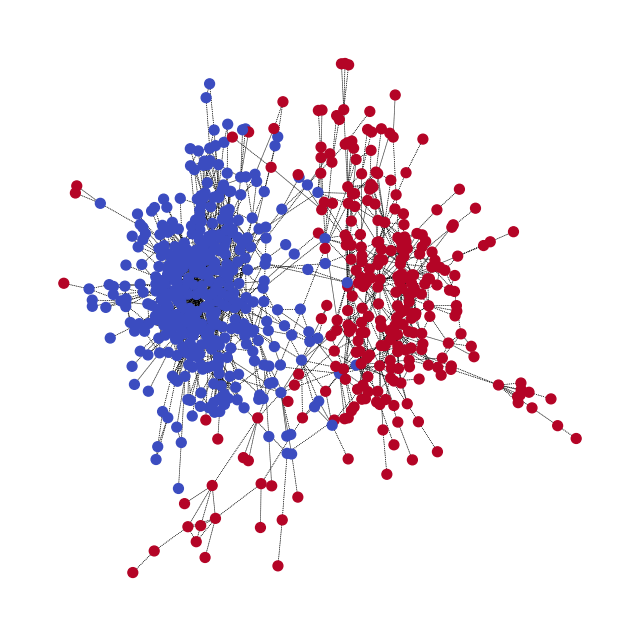

In [9]:
pmpd1 = sparse2th(pmpd1)
LG1 = G1.line_graph(backtracking=False)
z = model(G1, LG1, pmpd1)
_, pred = th.max(z, 1)
visualize(pred, nx_G1)

Compared with the ground truth. Note that the color might be reversed for the
two communities because the model is for correctly predicting the partitioning.



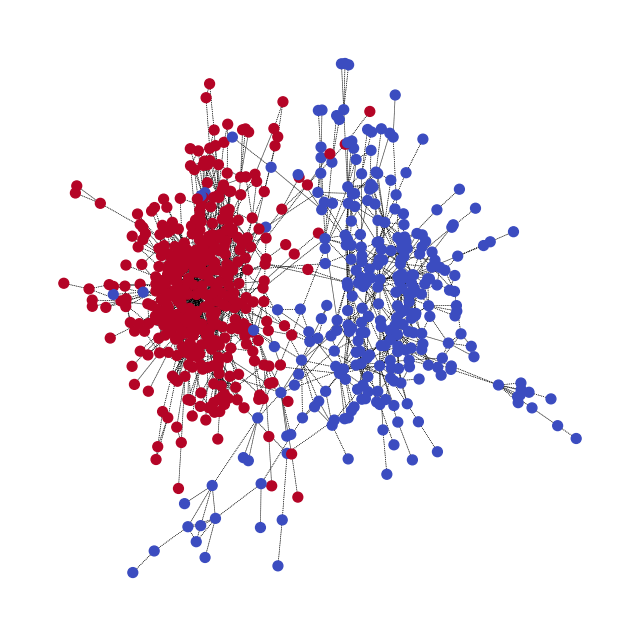

In [10]:
visualize(label1, nx_G1)

Here is an animation to better understand the process. (40 epochs)

.. figure:: https://i.imgur.com/KDUyE1S.gif
   :alt: lgnn-anim

## Batching graphs for parallelism

LGNN takes a collection of different graphs.
You might consider whether batching can be used for parallelism.

Batching has been into the data loader itself.
In the ``collate_fn`` for PyTorch data loader, graphs are batched using DGL's
batched_graph API. DGL batches graphs by merging them
into a large graph, with each smaller graph's adjacency matrix being a block
along the diagonal of the large graph's adjacency matrix.  Concatenate
:math`\{Pm,Pd\}` as block diagonal matrix in correspondence to DGL batched
graph API.



In [11]:
def collate_fn(batch):
    graphs, pmpds, labels = zip(*batch)
    batched_graphs = dgl.batch(graphs)
    batched_pmpds = sp.block_diag(pmpds)
    batched_labels = np.concatenate(labels, axis=0)
    return batched_graphs, batched_pmpds, batched_labels

You can find the complete code on Github at
[Community Detection with Graph Neural Networks (CDGNN)](https://github.com/dmlc/dgl/tree/master/examples/pytorch/line_graph).

